In [2]:
import argparse
import os
import random

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

try:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
except:
    pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# If you encounter some issues regarding cuda device, e.g., "RuntimeError: CUDA Out of memory error",
# try to switch the device to cpu by using the following code

# device = torch.device('cpu')

print('Device:', device)

!pip install onedrivedownloader

from onedrivedownloader import download

link1 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EQ9E0Sfcne5DghyvYekxvvwBSXJEaE-MMyNep7BkbqWvbA?e=OZNJcF'

link2 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EXV7Amf7tbxOrFPZvdIdcbcB3lx9tdGo8ccg1NVM6w-gQw?e=IER4ec'

if not os.path.exists('./data_hw4/anime'):
    print('Downloading dataset')
    download(link1, filename='./anime.zip', unzip=True, unzip_path='./data_hw4/anime')

if not os.path.exists('./pretrained'):
    print('Downloading pretrained weights')
    download(link2, filename='./gan_pretrained.zip', unzip=True, unzip_path='./pretrained')

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # TODO: Define each layer of the Generator based on the figure above (3 points)

        # Shapes of each layer: inputs -> outputs, (B, C, H, W)
                
        # conv1: (B, 100, 1, 1) -> (B, 128, 4, 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )

        # conv2: (B, 128, 4, 4) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )

        # conv3: (B, 64, 8, 8) -> (B, 32, 16, 16)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        # conv4: (B, 32, 16, 16) -> (B, 3, 32, 32)
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):        
        # TODO: Finish the forward-pass by using each defined layer above. (0.5 point)
        
        # Hints: You can also check the shape of intermediate outputs with the following code.
        # print(x.shape)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        return x

In [ ]:
# Create the Generator
model_G = Generator().to(device)
print(model_G, '\n')

B = 2
noises = torch.randn((B, 100, 1, 1), device=device)
images = model_G(noises) # It will call the `forward()` function when using `model_G()`.

print('Shape of input:', noises.shape)
print('Shape of output:', images.shape)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO: Define each layer of the Discriminator based on the figure above (3 points)

        # Shapes of each layer: inputs -> outputs, (B, C, H, W)
                
        # conv1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
        )

        # conv3: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):        
        # TODO: Finish the forward-pass by using each defined layer above. (0.5 point)
       
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # In the end, we convert the tensor to a vector to make the loss computation friendly
        # flatten: (B, 1, 1, 1) -> (B, )
        x = x.flatten()
        return x

In [ ]:
# Create the Discriminator
model_D = Discriminator().to(device)
print(model_D, '\n')

B = 2
images = torch.randn((B, 3, 32, 32), device=device)
outputs = model_D(images) # It will call the `forward()` function when using `model_D()`.

print('Shape of input:', images.shape)
print('Shape of output:', outputs.shape)

In [ ]:
"""def load_pretrained_weights(model_G, model_D, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    # TODO: Complete the code to load pretrained weights from local files. (1 point)
    
    # Hints: Call `torch.load()` to load the pretrained weights and pass `weights_G_path` and `weights_D_path` individually.
    weights_G = torch.load(weights_G_path)
    weights_D = torch.load(weights_D_path)
    
    # Hints: Call `load_state_dict()` and pass `weights_G` and `weights_D` individually.
    model_G.load_state_dict(weights_G)
    model_D.load_state_dict(weights_D)
    
    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape) """

In [ ]:
def load_pretrained_weights(model_G, model_D, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    # Load pretrained weights from local files
    weights_G = torch.load(weights_G_path, map_location=torch.device('cpu'))
    weights_D = torch.load(weights_D_path, map_location=torch.device('cpu'))

    # Load the state dictionaries into the models
    model_G.load_state_dict(weights_G)
    model_D.load_state_dict(weights_D)

    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape)

In [ ]:
# Now call the modified function
load_pretrained_weights(model_G, model_D, is_debug=True)
model_G = Generator().to(device)
model_D = Discriminator().to(device)

load_pretrained_weights(model_G, model_D, is_debug=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create the instances of Generator and Discriminator
model_G = Generator().to(device)
model_D = Discriminator().to(device)

# Create a group of fixed noise vectors for visualization.
fixed_noise = torch.randn((36, 100, 1, 1), device=device)

# Generate images with the random initialized Generator and display them.
generated_images = model_G(fixed_noise)
generated_images = utils.make_grid(generated_images.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[0].axis('off')
ax[0].set_title('Generated Images (random initialized)')
ax[0].imshow(np.transpose(generated_images, (1, 2, 0)))

# Load the pretrained weights of Generator and Discriminator on CelebA dataset.
load_pretrained_weights(model_G, model_D)

# Generate images with the random initialized Generator and display them.
generated_images_pretrained = model_G(fixed_noise)
generated_images_pretrained = utils.make_grid(generated_images_pretrained.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[1].axis('off')
ax[1].set_title('Generated Images (pretained)')
ax[1].imshow(np.transpose(generated_images_pretrained, (1, 2, 0)))

In [ ]:
# Image Size
image_size = 32

# Batch size during training
batch_size = 128
num_workers = 1

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(
    root='./data_hw4',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))

In [ ]:
def init_model_and_optimizer():

    # Create the instances of Generator and Discriminator
    model_G = Generator().to(device)
    model_D = Discriminator().to(device)

    # Load the pretraind weights of model_G and model_D
    load_pretrained_weights(model_G, model_D)

    # Setup Adam optimizers for both model_G and model_D
    optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Initialize the loss function for training
    BCE_loss = nn.BCELoss()
    
    return model_G, model_D, optimizer_G, optimizer_D, BCE_loss

In [ ]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

Device: cpu
Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
) 

Shape of input: torch.Size([2, 100, 1, 1])
Shape of output: torch.Size([2, 3, 32, 32])
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4,

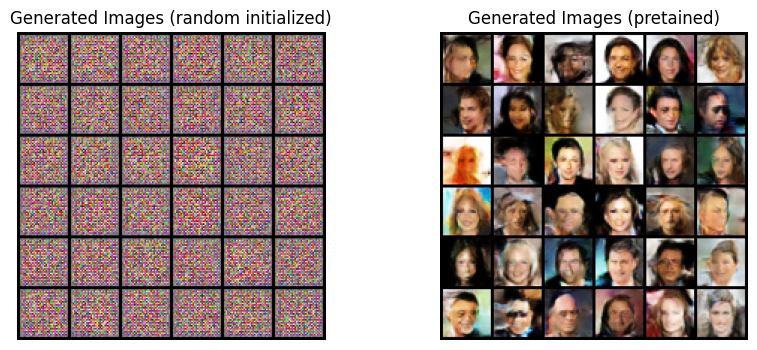

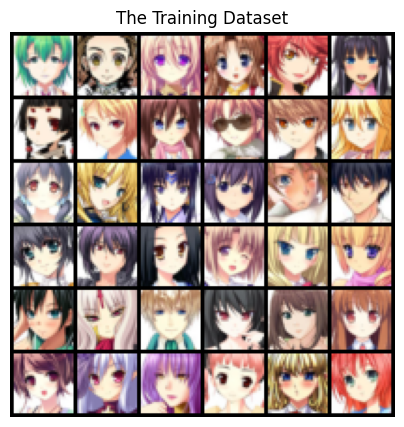

In [ ]:
def training_step_D(
    real_images,
    model_G: nn.Module,
    model_D: nn.Module, 
    optimizer_D: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Discriminator.

    Args:
        real_images: a batch of real image data from the training dataset.
        model_G: the Generator model
        model_D: the Discriminator model
        optimizer_D: optimizer of the Discriminator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_D: the Discriminator loss

    """

    # Resets the gradients of all parameters in Discriminator
    model_D.zero_grad()
    
    batch_size = real_images.shape[0]

    # Prepare the real images and their labels
    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size, ), device=device)
    
    # Prepare the fake images and their labels
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)
    fake_labels = torch.zeros((batch_size, ), device=device)

    
    # TODO: Call `model_D()` and `BCE_loss` to calculate the losses of real and fake images (2 points)
    # Hints: (1) pass `real_images` into `model_D()` to get the `real_outputs`.
    #        (2) calculate the `loss_D_real` with `real_outputs` and `real_labels` using `BCE_loss()`.
    #        (3) calculate the `loss_D_fake` following a similar way as (1)(2).
    real_outputs = model_D(real_images)
    loss_D_real = BCE_loss(real_outputs, real_labels)

    fake_outputs = model_D(fake_images)
    loss_D_fake = BCE_loss(fake_outputs, fake_labels)

    
    # Sum the loss of both real images and fake images.
    loss_D = loss_D_real + loss_D_fake
    
    # Compute the gradients
    loss_D.backward()
    
    # Update the parameters of `model_D`
    optimizer_D.step()

    if is_debug:
        print('Shape of real outputs:\n', real_outputs.shape, '\n')
        print('Shape and samples of real labels:\n', real_labels.shape, ' ', real_labels[:5], '\n')
        
        print('Shape of fake outputs:\n', fake_outputs.shape, '\n')
        print('Shape and samples of fake labels:\n', fake_labels.shape, ' ', fake_labels[:5], '\n')
    
    return loss_D

In [4]:
torch.manual_seed(0)

batch_data = torch.randn((batch_size, 3, 32, 32), device=device)
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_D = training_step_D(batch_data, model_G, model_D, optimizer_D, BCE_loss, is_debug=True)
print('Discriminator loss:\n', loss_D)

In [4]:
def training_step_G(
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_G: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Generator.

    Args:
        model_G: the Generator model
        model_D: the Discriminator model
        optimizer_G: optimizer of the Generator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_G: the Generator loss
    
    """

    # Reset the gradients of all parameters in `model_G`.
    model_G.zero_grad()
    
    # Generate fake images from `model_G` with random noises.
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)

    # Prepare labels for fake_images
    labels = torch.ones((batch_size, ), device=device)
    
    # Call `model_D()` and `BCE_loss` to calculate the loss of Generator
    outputs = model_D(fake_images)
    loss_G = BCE_loss(outputs, labels)

    # Compute the gradients
    loss_G.backward()
    
    # Update the parameters of `model_G`
    optimizer_G.step()

    if is_debug:
        print('Shape of outputs:\n', outputs.shape, '\n')
        print('Shape of labels:\n', labels.shape, '\n')

    return loss_G

In [4]:
torch.manual_seed(0)

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=True)

In [4]:
# Create the model, optimizer, and loss functions for training
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

# Lists and variables to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

torch.random.seed()
start_time = time.time()

# Training Loop
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(dataloader, 0):
        # Training step for Discriminator
        loss_D = training_step_D(real_images, model_G, model_D, optimizer_D, BCE_loss, is_debug=False)

        # Training step for Generator
        loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=False)

        # Output training stats
        if i % 50 == 0:
            print('[Epoch][Iter][{}/{}][{}/{}] Loss_D: {:.4f}, Loss_G: {:.4f}, Time: {:.2f} s'.format(
                epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), time.time() - start_time))
            start_time = time.time()

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = model_G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True, nrow=6))
        iters += 1

In [4]:
plt.figure()
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [4]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]

Shape of real outputs:
 torch.Size([128]) 

Shape and samples of real labels:
 torch.Size([128])   tensor([1., 1., 1., 1., 1.]) 

Shape of fake outputs:
 torch.Size([128]) 

Shape and samples of fake labels:
 torch.Size([128])   tensor([0., 0., 0., 0., 0.]) 

Discriminator loss:
 tensor(11.3854, grad_fn=<AddBackward0>)
Shape of outputs:
 torch.Size([128]) 

Shape of labels:
 torch.Size([128]) 

Starting Training Loop...
[Epoch][Iter][0/30][0/16] Loss_D: 2.0060, Loss_G: 0.8175, Time: 0.61 s
[Epoch][Iter][1/30][0/16] Loss_D: 0.0644, Loss_G: 4.2244, Time: 5.36 s
[Epoch][Iter][2/30][0/16] Loss_D: 0.0703, Loss_G: 4.6942, Time: 5.47 s
[Epoch][Iter][3/30][0/16] Loss_D: 0.2005, Loss_G: 6.1000, Time: 5.49 s
[Epoch][Iter][4/30][0/16] Loss_D: 0.1363, Loss_G: 4.2944, Time: 5.51 s
[Epoch][Iter][5/30][0/16] Loss_D: 0.4435, Loss_G: 2.2995, Time: 5.60 s
[Epoch][Iter][6/30][0/16] Loss_D: 0.2724, Loss_G: 3.7082, Time: 5.53 s
[Epoch][Iter][7/30][0/16] Loss_D: 0.4405, Loss_G: 4.4397, Time: 5.52 s
[Epoch][

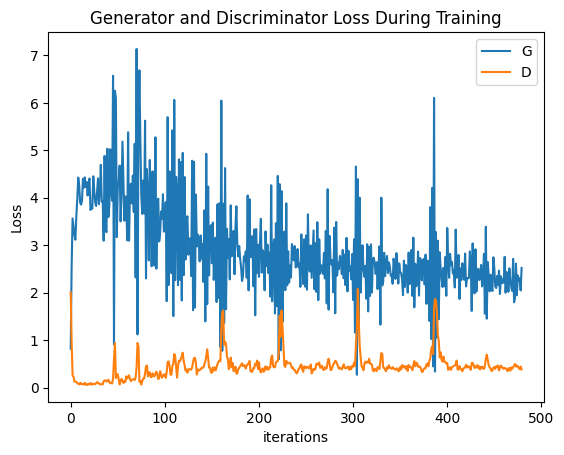

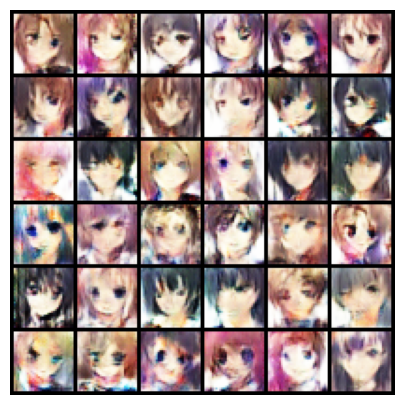

In [4]:
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())